# p53 Experiment in GPJax

Re-implementation of latent force functions using GPJax library

In [235]:
import numpy as np
import gpjax as gpx
import os
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from p53_dataset import JAXP53_Data, load_barenco_data, flatten_dataset_jax
jax.config.update('jax_enable_x64', True)

from matplotlib import rcParams
#plt.style.use("https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle")


colors = rcParams["axes.prop_cycle"].by_key()["color"]

The original data from *Barenco et al.* used a training set of $5$ known $p53$ target genes:

| **Target** | **Probeset** |
|----------|----------|
| *DDB2* | 203409_at  |
| *p21*  | 202284_s_at   |
| *SESN1/hPA26*   | 218346_s_at   |
| *BIK*   | 205780_at  |
| *TNFRSF10b*   | 209294_x_at, 209295_at, 210405_x_at   |

In [236]:
# Load the data
data_dir = os.path.join(os.getcwd(), '..', 'data')
(original_genes_df, genes_transformed), (tfs_df, tfs_transformed), gene_var, tf_var, times = load_barenco_data(data_dir)

In [237]:
def plot_all_genes_expression(original_df, transformed_expressions, gene_names, times):
    # Create a figure with 2 subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot all original expressions on the first subplot
    for gene_name in gene_names:
        # Calculate the mean of triplicates for the original expression levels
        original_means = original_df.loc[gene_name].values.reshape(7, 3).mean(axis=1)
        axes[0].plot(times, original_means, '-o', label=gene_name)
        
    axes[0].set_title('Original Expression Levels')
    axes[0].set_xlabel('Time (hours)')
    axes[0].set_ylabel('Expression Level')
    axes[0].legend()
    axes[0].grid(True)
    
    # Plot all log-normalized expressions on the second subplot
    for i, gene_name in enumerate(gene_names):
        # Calculate the mean of triplicates for the transformed expression levels
        transformed_means = transformed_expressions[i].reshape(7, 3).mean(axis=1)
        axes[1].plot(times, transformed_means, '-o', label=gene_name)
        
    axes[1].set_title('Log-normalized Expression Levels')
    axes[1].set_xlabel('Time (hours)')
    axes[1].set_ylabel('Transformed Expression Level')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

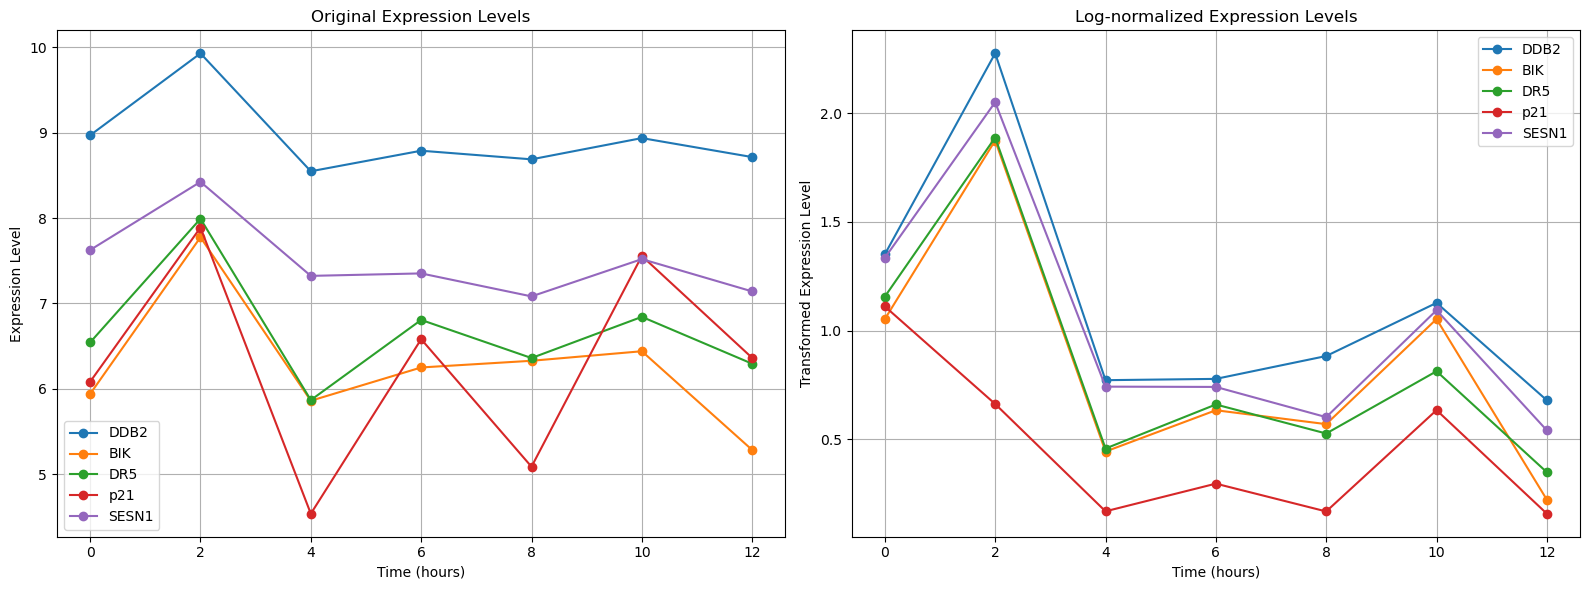

In [238]:
gene_names = ['DDB2', 'BIK', 'DR5', 'p21', 'SESN1', 'p53']  # Assuming these are your genes of interest
plot_all_genes_expression(original_genes_df, genes_transformed.swapaxes(0, 1), gene_names[:-1], times)

## Gaussian process implementation

Now that the data has been correctly pre-processed the Gaussian processes (GPs) can be implemented in `GPJax`.

In [239]:
p53_data = JAXP53_Data(replicate=2)
train_t , train_y = flatten_dataset_jax(p53_data)
type(train_t), type(train_y)

(jaxlib.xla_extension.ArrayImpl, jaxlib.xla_extension.ArrayImpl)

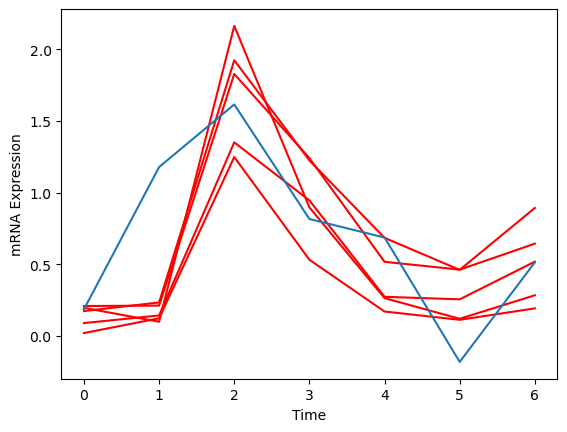

In [240]:
for i in range(5):
    plt.plot(p53_data.m_observed[0, i], color='red')
plt.plot(p53_data.f_observed[0, 0])
plt.xlabel('Time')
plt.ylabel('mRNA Expression')
plt.show()

In [241]:
# Define basal transcription rate (B), transcript degradation rate (D), sensitivity of gene (S)
def params_ground_truth():
    B_exact = np.array([0.0649, 0.0069, 0.0181, 0.0033, 0.0869])
    S_exact = np.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680])
    D_exact = np.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573])
    return B_exact, S_exact, D_exact

# Define transcription rates measured by Barenco et al. (plotted points on GP graph)
f_observed = np.array([0.1845,1.1785,1.6160,0.8156,0.6862,-0.1828, 0.5131])

## Using GPJax for transcriptional regulation modelling

1. Define GP Model
   - define kernel (RBF)
   - define likelihood
   - define mean function
2. Set the prior (done implicitly through choice of kernel & mean function)
3. Optimise hyperparameters of the GP model based on data
4. Make predictions & plot results

In [242]:
import gpjax as gpx
from dataclasses import dataclass
import jax.random as jr
from jax import jit

# Set random key
key = jr.PRNGKey(123)

# Prepare data (GPJax expects inputs as a 2D array)
X = train_t.reshape(-1, 1) 
Y = train_y.reshape(-1, 1)

x_test = np.linspace(0, 12, 100).reshape(-1, 1)
p53_gpjax_dataset = gpx.Dataset(X, Y)

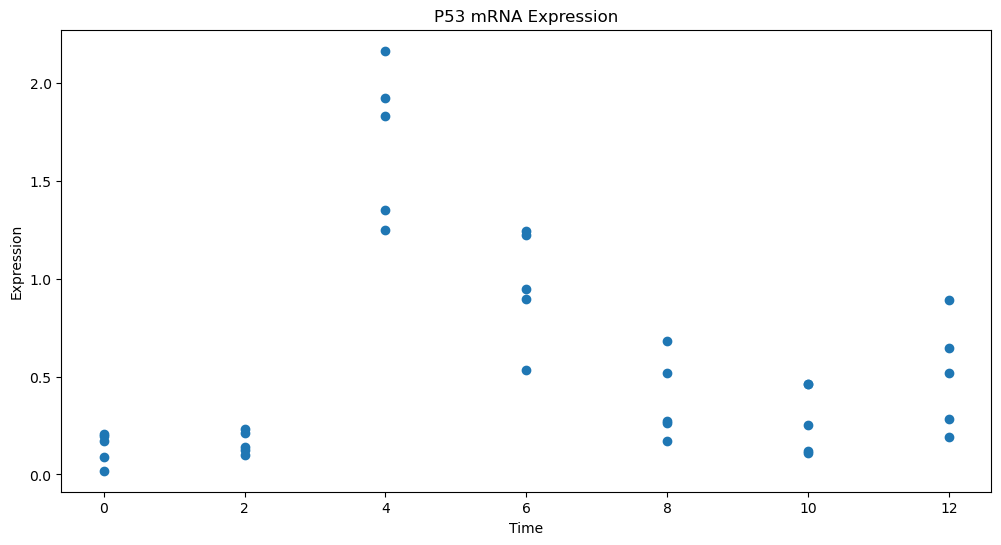

In [243]:
# Plot X and Y
plt.figure(figsize=(12, 6))
plt.plot(X, Y, 'o')
plt.xlabel('Time')
plt.ylabel('Expression')
plt.title('P53 mRNA Expression')
plt.show()

Prior over the latent function $f$ is taken to be RBF kernel:

$$
k_{ff}(t,t') = \exp \left(-\frac{(t-t')^2}{l^2}\right)
$$

Given that gene expression is related to $f$ via:

$$
x_{j}(t) = \frac{B_{j}}{D_{j}} + L_{j}[f](t)
$$

Then:

$$
\text{Cov}(L_{j}[f](t), L_{k}[f](t')) = L_{j} \otimes L_{k}k_{ff}
$$

Or:

$$
k_{x_{j}x_{k}}(t,t') = S_{j}S_{k}e^{-D_{j}t-D_{k}t'}\int_{0}^{t}e^{D_{j}u}\int_{0}^{t'}e^{D_{k}u'}k_{ff}(u,u')\mathrm{d} u'\mathrm{d} u
$$

If the RBF kernel is used as the base kernel, this can be analytically solved to give the following expression for the covariance function:

$$
k_{x_{j}x_{k}}(t,t') = S_{j}S_{k}\frac{\sqrt{\pi}l}{2}[h_{kj}(t,t') + h_{kj}(t',t)]
$$

where

\begin{align*}
h_{kj}(t,t') &= \frac{\exp(\gamma_{k})^{2}}{D_{j} + D_{k}} \left\{ \exp[-D_{k}(t'-t)] \right. \\
&\quad \left. \left[ \text{erf} \left(\frac{t'-t}{l_{r}} - \gamma_{k}\right) + \text{erf} \left(\frac{t}{l_{r}} + \gamma_{k} \right) \right]  \right. \\
&\quad \left. - \exp[-(D_{k}t'+D_{j}t)] \left[ \text{erf} \left(\frac{t'}{l_{r}} - \gamma_{k}\right) + \text{erf} \left(\gamma_{k} \right) \right] \right\}
\end{align*}

where $\textrm{erf}(x)$ is the real-valued error function, $\textrm{erf}(x) = \frac{2}{\sqrt{\pi}}\int_{0}^{x} \textrm{exp}(-y^{2}) \mathrm{d} y$, and $\gamma_{k} = \frac{D_{k}l}{\sqrt{2}}$.


In [244]:
# Coding up h function
# Optimise for lengthscale and d


def gamma(d, k, l):
    # Gamma term for h function
    return (d[k] * l) / jnp.sqrt(2)

def h(l, d, j, k, t1, t2):
    """ 
    Analytical solution for the convolution of the exponential kernel with a step function.

    Parameters
    ----------
    l : float
        Lengthscale parameter of the kernel.
    d : array
        decay rate of genes (optmisied for)
    j : int
        Index of jth gene.
    k : int
        Index of kth gene.
    t1 : float
        time one
    t2 : float
        time two

    """
    t_dist = t2 - t1
    # Might be jnp.exp(gamma**2) instead of jnp.exp(gamma)**2
    multiplier = jnp.exp(gamma(d, k, l))**2 / (d[j] + d[k])
    first_multiplier = jnp.exp(-d[k]*t_dist)
    first_erf_terms = jax.scipy.special.erf((t_dist / l) - gamma(d, k, l)) + jax.scipy.special.erf(t1/l + gamma(d, k, l))
    second_multiplier = jnp.exp(-(d[k]*t2 + d[j]*t1))
    second_erf_terms = jax.scipy.special.erf((t2 / l) - gamma(d, k, l)) + jax.scipy.special.erf(gamma(d, k, l))

    return multiplier *(jnp.multiply(first_multiplier, first_erf_terms) + jnp.multiply(second_multiplier, second_erf_terms))
    

Next, we define a custom kernel which handles three different covariance functions:

- $k_{xx}$: Covariance between measured gene expressions (eq. 5)
- $k_{xf}$: 'Cross-covariance' between gene expressions and force function
- $k_{ff}$: Covariance between latent force functiond (RBF)


to equation (5) from *Modelling transcriptional regulation using Gaussian processes* which is shown above. To do this, the custom kernel notebook was followed and limits were set on the parameters.

$$
k_{x_{j}f_{r}}(t,t') = \frac{S_{rj}\sqrt{\pi}l_{r}}{2} \textrm{exp}(\gamma_{j})^{2}\textrm{exp}(-D_{j}(t'-t)) \biggl[ \textrm{erf} \left (\frac{t'-t}{l_{r}} - \gamma_{k}\right ) + \textrm{erf} \left (\frac{t}{l_{r}} +\gamma_{k} \right ) \biggr]
$$

In [245]:
# TODO: define custom kernel
# TODO: define mean function

from beartype.typing import Union
from jaxtyping import Float
from gpjax.typing import (
    Array,
    ScalarFloat,
)

import tensorflow_probability.substrates.jax.bijectors as tfb

from gpjax.base import param_field
from gpjax.kernels.base import AbstractKernel

@dataclass
class SIM(AbstractKernel):
    """
    Simple Imput Motif Kernel

    Kernel for linear response to a single transcription factor
    """
    dtype = jnp.float32
    name: str = 'SIM'
    num_genes: int = 5
    # Initialise these by taking the inverse of the constraints
    
    # Limit l to interval 0.5, 3.5: maps [0, 1] -> [0.5, 3.5]
    l_constraint = tfb.Chain([tfb.Shift(0.5), tfb.Scale(3.0)])
    initial_l = l_constraint.inverse(2.5 * jnp.ones((1,1),dtype=dtype))
    lengthscale: Union[ScalarFloat, Float[Array, " D"]] =  param_field(initial_l, bijector=tfb.Invert(l_constraint))

    # Get active dimensions from base kernel
    # active_dims or ndims? Using 5 for now
    pos_constraint = tfb.Softplus()
    
    # Decay rates per gene (list) must be positive
    initial_decays = pos_constraint.inverse(0.4 * jnp.ones(num_genes, dtype=dtype))
    decays: Array = param_field(initial_decays, bijector=tfb.Invert(pos_constraint))

    # Sensitivities per gene (list) must be positive
    initial_sensitivities = pos_constraint.inverse(1 * jnp.ones(num_genes, dtype=dtype))
    sensitivities: Array = param_field(initial_sensitivities, bijector=tfb.Invert(pos_constraint))

    # Noise level
    initial_noise = pos_constraint.inverse(0.1 * jnp.ones(num_genes, dtype=dtype))
    noise: ScalarFloat = param_field(initial_noise, bijector=tfb.Invert(pos_constraint))

    # Classical GPR: think of f as testing points and x as training points
    @jit   
    def _Kxx(self, t1: jnp.ndarray, t2: jnp.ndarray) -> jnp.ndarray:
        """ 
        Covariance matrix between gene expressions at times t' and t.
        Uses equation 5 in paper (in _kxx function)

        Parameters
        ----------
        t1, t2 : array
            Time points for gene expressions at times t and t'. Shape (n, r) where n is the number of time points and r is the number of replicates.
        """
        vert_block_size = t1.shape[0] // self.num_genes
        horiz_block_size = t2.shape[0] // self.num_genes

        t1_block = t1[:vert_block_size]
        t2_block = t2[:horiz_block_size]

        shape = shape = (vert_block_size * self.num_genes, horiz_block_size * self.num_genes)
        K_xx = jnp.zeros(shape)

        # Fill in covariance matrix
        for j in range(self.num_genes):
            for k in range(self.num_genes):
                kxx = self._kxx(j, k, t1_block, t2_block)
                #kxx = 0.7
                K_xx = K_xx.at[j * vert_block_size:(j + 1) * vert_block_size,
                                k * horiz_block_size:(k + 1) * horiz_block_size].set(kxx)
        
        # Add jitter
        if horiz_block_size == vert_block_size:
            jitter = 1e-3 * jnp.eye(K_xx.shape[0])
            K_xx += jitter
            #TODO: look at variance
            
        print(t1_block, t2_block)
        return K_xx
    
    def _kxx(self, j, k, t1_block, t2_block):
        """
        Equation 5 in paper k_xx(t, t')

        Parameters
        ----------
        j, k : int
            Index of jth and kth gene.
        t1_block, t2_block : array
            Block of time points for gene expressions at times t and t'. Shape (n,)
        """

        mult = self.sensitivities[j] * self.senstivities[k] * self.lengthscale * jnp.sqrt(jnp.pi) * 0.5
        second_term = self._h(k, j, t2_block, t1_block) + self._h(j, k, t1_block, t2_block)

        return mult * second_term
    
    def _h(self,j,k,t1,t2):
        """
        Analytical solution for the convolution of the exponential kernel with a step function.

        Parameters
        ----------
        j, k : int
            Index of jth and kth gene.
        t1, t2 : float
            time one and time two
        """
        t_dist = t2 - t1
        # NOTE: Might be jnp.exp(gamma**2) instead of jnp.exp(gamma)**2
        multiplier = jnp.exp(self._gamma(k))**2 / (self.decays[j] + self.decays[k])
        first_multiplier = jnp.exp(-self.decays[k]*t_dist)
        first_erf_terms = jax.scipy.special.erf((t_dist / self.lengthscale) - self._gamma(k)) + jax.scipy.special.erf(t1/self.lengthscale + self._gamma(k))
        second_multiplier = jnp.exp(-(self.decays[k]*t2 + self.decays[j]*t1))
        second_erf_terms = jax.scipy.special.erf((t2 / self.lengthscale) - self._gamma(k)) + jax.scipy.special.erf(self._gamma(k))

        result = multiplier *(jnp.multiply(first_multiplier, first_erf_terms) + jnp.multiply(second_multiplier, second_erf_terms))

        return result

    def _gamma(self,k):
        # Gamma term for h function
        return (self.decays[k] * self.lengthscale) / jnp.sqrt(2)        

    # TODO: implement cross-covariance functions
    def _Kxf(self, x: jnp.ndarray, t: jnp.ndarray) -> jnp.ndarray:
        """
        Cross-covariance between gene expressions at time t' and f at time t.
        Equation 6 in paper
        """
        return None
    
    def _Kff(self, t1: jnp.ndarray, t2: jnp.ndarray) -> jnp.ndarray:
        """
        Covariance between f at times t' and t.
        RBF
        """
        # Unsure if calling RBF kernel would be quicker
        rbf = jnp.exp(-0.5 * jnp.square(t1 - t2) / jnp.square(self.lengthscale))
        if rbf.shape[0] == rbf.shape[1]:
            jitter = 1e-3 * jnp.eye(rbf.shape[0])
            rbf += jitter
        return rbf
        
    # Define __call__ method for use in GPJax
    # Use switch based on input sizes to alternate between Kxx and Kxf
    def __call__() -> None:
        pass

In [246]:
test_t = jnp.array([ 0.,  2.,  4.,  6.,  8., 10., 12.,  0.,  2.,  4.,  6.,  8., 10.,
       12.,  0.,  2.,  4.,  6.,  8., 10., 12.,  0.,  2.,  4.,  6.,  8.,
       10., 12.,  0.,  2.,  4.,  6.,  8., 10., 12.])

num_genes = 5
# Dummy variables for parameters to optimise for
lengthscale = 2.5
decays = jnp.array([0.2829, 0.3720, 0.3617, 0.8000, 0.3573])
senstivities = jnp.array([0.9075, 0.9748, 0.9785, 1.0000, 0.9680])
noise = jnp.array([0.001, 0.001, 0.001, 0.001, 0.001])

In [306]:
# Plotting kernels
def plot_cov_heatmap(cov_matrix):

    plt.figure(figsize=(8, 6))
    plt.imshow(cov_matrix, cmap='viridis')
    plt.colorbar()
    plt.xlabel('T1')
    plt.ylabel('T2')
    plt.title('Covariance Matrix')
    plt.show()

In [248]:
# Test implementation of Kxx
def Kxx(t1, t2):
    vert_block_size = t1.shape[0] // num_genes
    horiz_block_size = t2.shape[0] // num_genes

    t1_block = t1[:vert_block_size]
    t2_block = t2[:horiz_block_size]

    shape = shape = (vert_block_size * num_genes, horiz_block_size * num_genes)
    K_xx = jnp.zeros(shape)

    # Fill in covariance matrix
    for j in range(num_genes):
        for k in range(num_genes):
            kxx = _kxx(j, k, t1_block, t2_block)
            #kxx = 0.7
            K_xx = K_xx.at[j * vert_block_size:(j + 1) * vert_block_size,
                               k * horiz_block_size:(k + 1) * horiz_block_size].set(kxx)
    
    # Add jitter
    if horiz_block_size == vert_block_size:
        jitter = 1e-3 * jnp.eye(K_xx.shape[0])
        K_xx += jitter
        #TODO: look at variance
        
    return K_xx

def _kxx(j, k, t1_block, t2_block):
    """
    Equation 5 in paper k_xx(t, t')

    Parameters
    ----------
    j, k : int
        Index of jth and kth gene.
    t1_block, t2_block : array
        Block of time points for gene expressions at times t and t'. Shape (n,)
    """

    mult = senstivities[j] * senstivities[k] * lengthscale * jnp.sqrt(jnp.pi) * 0.5
    second_term = _h(k, j, t2_block, t1_block) + _h(j, k, t1_block, t2_block)


    return mult * second_term


def _h(j,k,t1,t2):
    """
    Analytical solution for the convolution of the exponential kernel with a step function.

    Parameters
    ----------
    j, k : int
        Index of jth and kth gene.
    t1, t2 : float
        time one and time two
    """
    t_dist = t2 - t1
    # NOTE: Might be jnp.exp(gamma**2) instead of jnp.exp(gamma)**2
    multiplier = jnp.exp(_gamma(k))**2 / (decays[j] + decays[k])
    first_multiplier = jnp.exp(-decays[k]*t_dist)
    first_erf_terms = jax.scipy.special.erf((t_dist / lengthscale) - _gamma(k)) + jax.scipy.special.erf(t1/lengthscale + _gamma(k))
    second_multiplier = jnp.exp(-(decays[k]*t2 + decays[j]*t1))
    second_erf_terms = jax.scipy.special.erf((t2 / lengthscale) - _gamma(k)) + jax.scipy.special.erf(_gamma(k))

    result = multiplier *(jnp.multiply(first_multiplier, first_erf_terms) + jnp.multiply(second_multiplier, second_erf_terms))

    return result


def _gamma(k):
    # Gamma term for h function
    return (decays[k] * lengthscale) / 2

In [249]:
import torch
time_points = torch.linspace(0, 12, 100)

x1 = time_points.repeat(num_genes, 1).view(-1)
x2 = x1

# Convert x1 and x2 to jax arrays
x1 = jnp.array(x1)
x2 = jnp.array(x2)

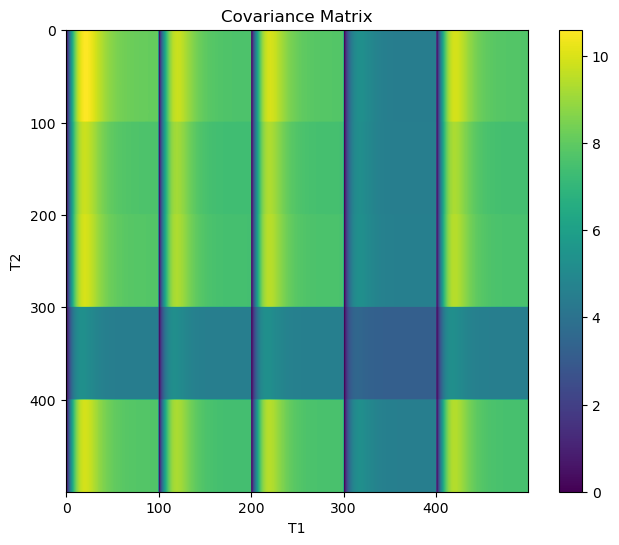

In [250]:
K_xx = Kxx(x1, x2)

# Plot covariance matrix
# Looks wrong
plot_cov_heatmap(K_xx)

In [251]:
tblock1 = jnp.array([0.,  2.,  4.,  6.,  8., 10., 12.])
tblock2 = jnp.array([0.,  2.,  4.,  6.,  8., 10., 12.])

In [252]:
# Generate jnp array of size (80,)
test_jnp = jnp.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
test_jnp[:2].reshape(-1,1).shape

(2, 1)

### Pytorch implementation of kxx

In [309]:
# Pytorch implementation of kxx

def torch_Kxx(t1, t2):
    # Torch implementation of Kxx
    # Convert t1 and t2 to torch tensors
    t1 = torch.tensor(np.array(t1))
    t2 = torch.tensor(np.array(t2))
    
    vert_block_size = int(t1.shape[0] / num_genes)
    hori_block_size = int(t2.shape[0] / num_genes)
    t1_block, t2_block = t1[:vert_block_size], t2[:hori_block_size]
    shape = [vert_block_size * num_genes, hori_block_size * num_genes]
    K_xx = torch.zeros(shape, dtype=torch.float64)
    for j in range(num_genes):
        for k in range(num_genes):
            kxx = torch_kxx(j, k, t1_block, t2_block)
            K_xx[j * vert_block_size:(j + 1) * vert_block_size,
                    k * hori_block_size:(k + 1) * hori_block_size] = kxx

    if hori_block_size == vert_block_size:
        # noise = self.noise.view(-1, 1).repeat(1, hori_block_size).view(-1)
        # noise = torch.diag(noise)
        jitter = 1e-4 * torch.eye(K_xx.shape[0], dtype=torch.float64)
        K_xx += jitter
        #if K_xx.shape[0] == self.variance.shape[0]:
            #K_xx += self.variance
    
    return K_xx



def torch_kxx(j, k, t1_block, t2_block):

    t1_block = t1_block.view(-1, 1)
    t2_block = t2_block.view(1, -1)


    PI = torch.tensor(np.pi, requires_grad=False)
    senstivities_torch = torch.tensor(np.array(senstivities))
    
    mult = senstivities_torch[j] * senstivities_torch[k] * lengthscale * 0.5 * torch.sqrt(PI)
    k_xx = mult * (torch_h(k, j, t2_block, t1_block) + torch_h(j, k, t1_block, t2_block))
    return k_xx

def torch_h(j, k, t1, t2):
    l = lengthscale
    t_dist = t2 - t1

    decays_torch = torch.tensor(np.array(decays))

    multiplier = torch.exp(torch_gamma(k) ** 2) / (decays_torch[j] + decays_torch[k])  # (1, 1)
    first_erf_term = torch.erf(t_dist / l - torch_gamma(k)) + torch.erf(t1 / l + torch_gamma(k))  # (T,T)
    second_erf_term = torch.erf(t2 / l - torch_gamma(k)) + torch.erf(torch_gamma(k))
    return multiplier * (torch.multiply(torch.exp(-decays_torch[k] * t_dist), first_erf_term) - \
                            torch.multiply(torch.exp(-decays_torch[k] * t2 - decays_torch[j] * t1), second_erf_term))

def torch_gamma(k):
    res = decays[k] * lengthscale / 2
    return torch.tensor(np.array(res))

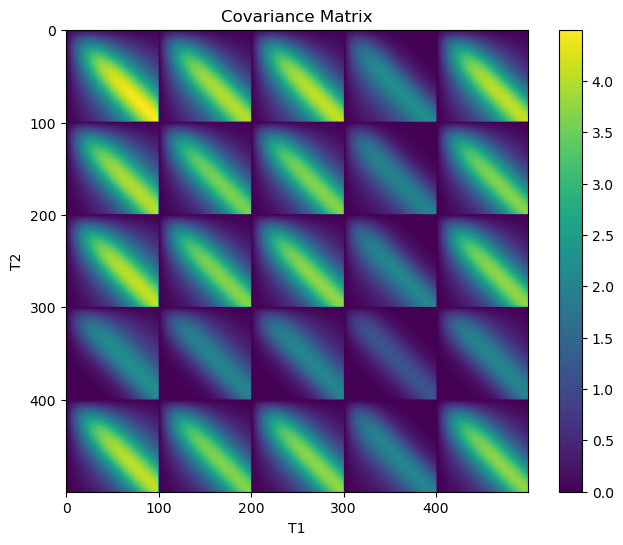

In [313]:
K_xx_torch = torch_Kxx(x1, x2)
plot_cov_heatmap(K_xx_torch)

In [283]:
# Test implementation of Kxt
def Kxf(x, f):
    """
    Cross-covariance between gene expressions at time t' and f at time t.
    Equation 6 in paper

    Parameters
    ----------
    x : array
        Time points for gene expressions at times t'. Shape (n,)
    f : array
        Time points for f at times t. Shape (m,)
    """
    # Get shape (n, m)
    K_xf = jnp.zeros((x.shape[0], f.shape[0]))
    block_size = x.shape[0] // num_genes #7
    t1_block = x[:block_size].reshape(-1, 1)
    t2_block = f.reshape(1, -1)

    for j in range(num_genes):
        kxf = _kxf(j, t1_block, t2_block)
        K_xf = K_xf.at[j * block_size:(j + 1) * block_size].set(kxf)
    
    return K_xf

def _kxf(j, t_x, t_f):
    l = lengthscale
    t_dist = t_x - t_f
    
    first_term = 0.5 * l * jnp.sqrt(jnp.pi) * senstivities[j]
    first_expon_term = jnp.exp(_gamma(j)**2)
    second_expon_term = jnp.exp(-decays[j]*t_dist)
    erf_terms = jax.scipy.special.erf((t_dist / l) - _gamma(j)) + jax.scipy.special.erf(t_f/l + _gamma(j))

    kxf = first_term * first_expon_term * second_expon_term * erf_terms

    return kxf  

In [284]:
t_predict = torch.linspace(0, 13, 80, dtype=torch.float64)
t_predict = jnp.array(t_predict)

In [303]:
Kxf_result = Kxf(X, t_predict)
numpy_kxf = np.array(Kxf_result)

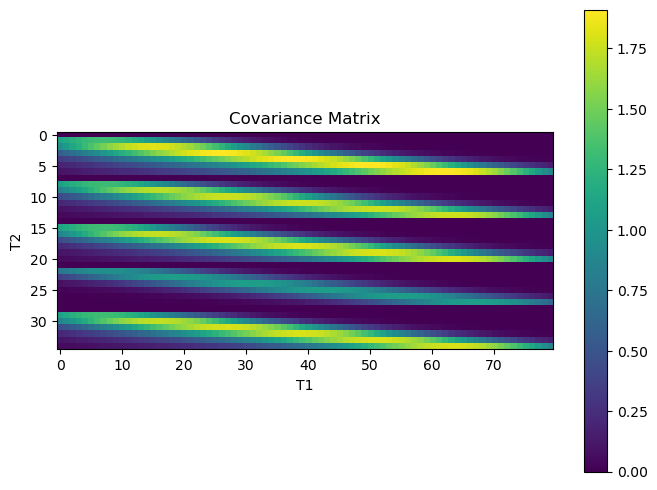

In [304]:
plot_cov_heatmap(Kxf_result)

In [137]:
# Load K_xf.npy as torch_kxf
torch_kxf = np.load('K_xf.npy')

In [279]:
# From torch
def torch_K_xf(x, f):
    """
    K_xf
    Cross-covariance. Not optimised (not in marginal likelihood).
    Parameters:
        x: tensor (JT, JT) the blocked observation vector
        f: tensor (T*) the non-blocked f prediction timepoint vector
    """
    #convert x and f to numpy arrays then torch tensors
    x = torch.tensor(np.array(x))
    f = torch.tensor(np.array(f))
    shape = [x.shape[0], f.shape[0]]
    K_xf = torch.zeros(shape, dtype=torch.float32)
    block_size = int(x.shape[0] / num_genes)  # 7
    t1_block, t2_block = x[:block_size].view(-1, 1), f.view(1, -1)
    for j in range(num_genes):
        kxf = torch_k_xf(j, t1_block, t2_block)
        K_xf[j * block_size:(j + 1) * block_size] = kxf
    

    return K_xf

def torch_k_xf(j, x, t_f):
    PI = torch.tensor(np.pi, requires_grad=False)
    l = lengthscale
    t_dist = x - t_f

    decays_torch = torch.tensor(np.array(decays))
    senstivities_torch = torch.tensor(np.array(senstivities))
    
    erf_term = torch.erf((t_dist / l) - torch_gamma(j)) + torch.erf(t_f / l + torch_gamma(j))
    return senstivities_torch[j] * l * 0.5 * torch.sqrt(PI) * torch.exp(torch_gamma(j) ** 2) * torch.exp(
        -decays_torch[j] * t_dist) * erf_term

def torch_gamma(k):
    res = decays[k] * lengthscale / 2
    return torch.tensor(np.array(res))

In [280]:
Kxf_torch_result = torch_K_xf(X, t_predict)

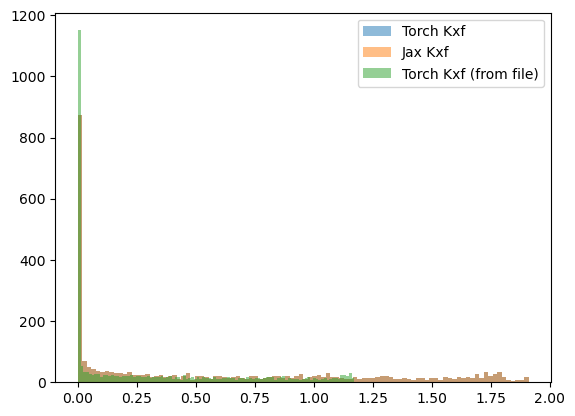

In [305]:
plt.hist(Kxf_torch_result.flatten(), bins=100, alpha=0.5, label='Torch Kxf')
plt.hist(numpy_kxf.flatten(), bins=100, alpha=0.5, label='Jax Kxf')
plt.hist(torch_kxf.flatten(), bins=100, alpha=0.5, label='Torch Kxf (from file)')
plt.legend()
plt.show()

In [74]:
# Test implementation of Kff (RBF kernel)

def Kff(t1, t2):
    """
    Covariance between f at times t' and t.
    RBF
    """
    # Unsure if calling RBF kernel would be quicker
    
    # Ensure inputs are column vectors
    t1 = t1.reshape(-1, 1)
    t2 = t2.reshape(1, -1)

    rbf = jnp.exp(-0.5 * jnp.square(t1 - t2) / jnp.square(lengthscale))
    if rbf.shape[0] == rbf.shape[1]:
        jitter = 1e-3 * jnp.eye(rbf.shape[0])
        rbf += jitter
    return rbf

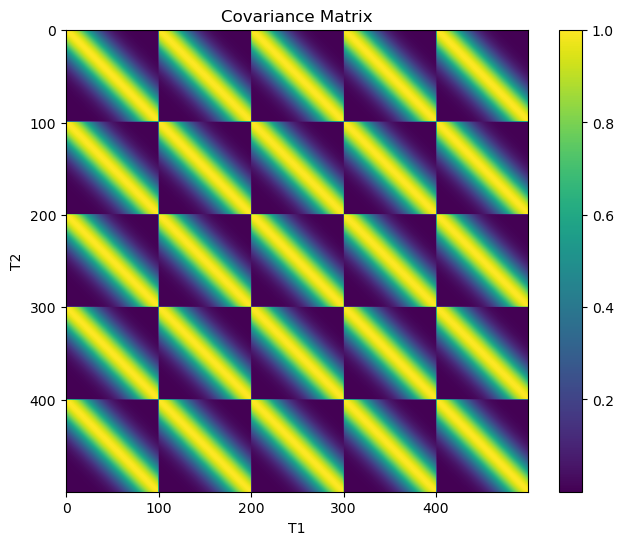

In [111]:
kff_cov = Kff(x1, x2)

plot_cov_heatmap(kff_cov)

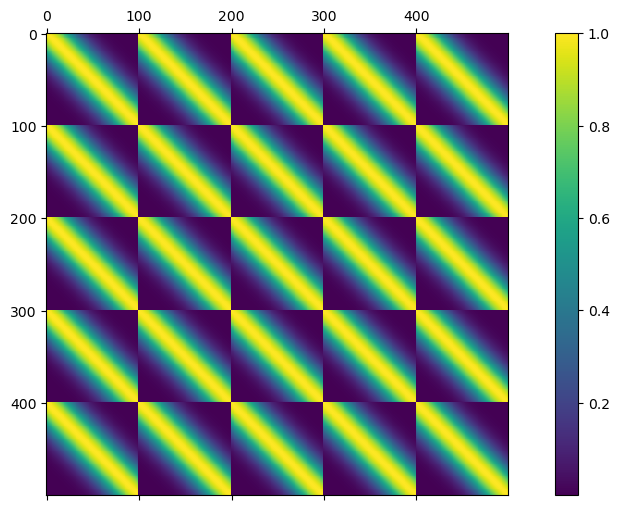

In [112]:
# Import RBF kernel from GPJax
from gpjax.kernels import RBF   

# Define the kernel
k_rbf = RBF(variance=1.0, lengthscale=2.5)

# Compute the covariance matrix
cov_rbf = k_rbf.gram(test_t)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
im0 = ax.matshow(k_rbf.gram(x1).to_dense())
fig.colorbar(im0)

In [66]:
Kff(test_t, test_t)

Array([[1.00100000e+00, 7.26149037e-01, 2.78037300e-01, ...,
        5.97602290e-03, 3.35462628e-04, 9.92950431e-06],
       [7.26149037e-01, 1.00100000e+00, 7.26149037e-01, ...,
        5.61347628e-02, 5.97602290e-03, 3.35462628e-04],
       [2.78037300e-01, 7.26149037e-01, 1.00100000e+00, ...,
        2.78037300e-01, 5.61347628e-02, 5.97602290e-03],
       ...,
       [5.97602290e-03, 5.61347628e-02, 2.78037300e-01, ...,
        1.00100000e+00, 7.26149037e-01, 2.78037300e-01],
       [3.35462628e-04, 5.97602290e-03, 5.61347628e-02, ...,
        7.26149037e-01, 1.00100000e+00, 7.26149037e-01],
       [9.92950431e-06, 3.35462628e-04, 5.97602290e-03, ...,
        2.78037300e-01, 7.26149037e-01, 1.00100000e+00]], dtype=float64)

$$
k(x,y)=\sigma^2\exp\Bigg(- \frac{\lVert x - y \rVert^2_2}{2 \ell^2} \Bigg)
$$

In [20]:
# Implement mean function